In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=10, repeats=1):

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=123)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring='r2',
                               verbose=True, return_train_score=True, n_jobs=4)

        gsearch.fit(X,y)
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_
        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring='r2', cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    plt.figure(figsize=(12,4))
    ax_121 = plt.subplot(1,2,1)
    plt.plot(y_pred,y,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    #cv_results = cross_val_predict(model, X, y, n_jobs = 4, cv=splits)
    
    ax_122=plt.subplot(1,2,2)
    plt.plot(y_pred,y-y_pred,'.')
    plt.ylim((-4,4))
    plt.xlabel('y_pred')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    plt.show()

    return model, cv_score, grid_results

In [3]:
df_drug_response = pd.read_csv('For_FilnalReport.csv',index_col=0)

In [4]:
features = list(df_drug_response.columns)[:451]
df_x = df_drug_response.loc[:,features]
df_y = df_drug_response['ERLOTINIB']

In [5]:
print(df_drug_response.info())

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, LC1SQSF_LUNG to NCIH2405_LUNG
Columns: 913 entries, RBM5 to ERLOTINIB
dtypes: float64(453), int64(460)
memory usage: 1.3+ MB
None


In [7]:
df_drug_response.isnull()

,RBM5,CDC27,CREBBP,MED24,CSDE1,MAP4K3,BRCA1,HGF,AQR,VIM,...,ZFHX3_mut,ZFP36L1_mut,ZFP36L2_mut,ZMYM2_mut,ZNF292_mut,ZNF638_mut,ZNF750_mut,ZNF814_mut,ZNRF3_mut,ERLOTINIB
LC1SQSF_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NCIH1395_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LC1F_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
ABC1_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
LK2_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH292_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
NCIH23_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NCIH1355_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
HCC515_LUNG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [8]:
df_drug_response_drop=df_drug_response.dropna()

In [9]:
df_drug_response_drop

,RBM5,CDC27,CREBBP,MED24,CSDE1,MAP4K3,BRCA1,HGF,AQR,VIM,...,ZFHX3_mut,ZFP36L1_mut,ZFP36L2_mut,ZMYM2_mut,ZNF292_mut,ZNF638_mut,ZNF750_mut,ZNF814_mut,ZNRF3_mut,ERLOTINIB
LC1SQSF_LUNG,5.286142,6.624393,4.061776,5.305971,8.147815,4.422906,5.430954,0.084064,3.460743,8.357596,...,1,0,0,0,0,0,0,0,0,12.743
NCIH1395_LUNG,4.886062,4.581954,3.297191,4.504620,6.460906,4.363872,3.144046,0.678072,2.784504,1.475085,...,0,0,0,0,0,0,0,0,0,14.083
LK2_LUNG,5.810957,5.151372,4.660495,6.258707,7.927304,4.107688,5.272770,0.150560,4.119356,2.584963,...,0,0,0,0,0,0,0,0,1,14.995
NCIH446_LUNG,5.717539,5.590063,3.965323,5.957682,8.637893,3.993674,4.674122,7.003152,3.768714,7.264067,...,1,0,1,0,0,0,0,0,0,13.862
LOUNH91_LUNG,6.056367,5.632850,3.979111,5.478648,8.002365,3.797013,5.080658,0.056584,3.746313,10.588340,...,0,0,0,0,1,1,0,0,0,13.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH1581_LUNG,6.151575,5.197315,3.563158,6.573647,8.016363,3.536053,4.541019,5.572283,4.146492,11.175362,...,0,0,0,0,0,0,0,0,0,12.593
RERFLCAD1_LUNG,6.464668,5.465974,4.401221,5.940402,8.182146,4.341274,5.375039,0.137504,4.386121,8.860466,...,0,0,0,0,0,0,0,0,0,15.282
NCIH23_LUNG,5.861955,5.880686,3.857981,6.084702,9.259296,3.994580,4.669594,1.575312,4.084064,10.172803,...,0,0,0,0,0,0,0,0,0,14.744
NCIH1355_LUNG,6.033643,6.123087,3.899176,5.477030,7.619413,3.599318,4.735522,0.042644,3.969012,8.793798,...,0,0,0,0,0,0,0,0,0,12.443


In [11]:
print(df_drug_response.isnull().sum())
print('---------------------')
print(df_drug_response.isnull().sum().sum())
print("---------------------")
print(df_drug_response_drop.isnull().sum())
print("---------------------")
print(df_drug_response_drop.isnull().sum().sum())

RBM5           0
CDC27          0
CREBBP         0
MED24          0
CSDE1          0
              ..
ZNF638_mut     0
ZNF750_mut     0
ZNF814_mut     0
ZNRF3_mut      0
ERLOTINIB     57
Length: 913, dtype: int64
---------------------
57
---------------------
RBM5          0
CDC27         0
CREBBP        0
MED24         0
CSDE1         0
             ..
ZNF638_mut    0
ZNF750_mut    0
ZNF814_mut    0
ZNRF3_mut     0
ERLOTINIB     0
Length: 913, dtype: int64
---------------------
0


In [16]:
df_x=df_drug_response_drop.loc[:,features]
df_y=df_drug_response_drop['ERLOTINIB']

In [25]:
data_x = df_x
data_y = df_y

scaler = StandardScaler()
scaled_val = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_val, columns=data_x.columns)

Fitting 25 folds for each of 1000 candidates, totalling 25000 fits
----------------------
Lasso(alpha=0.489)
----------------------


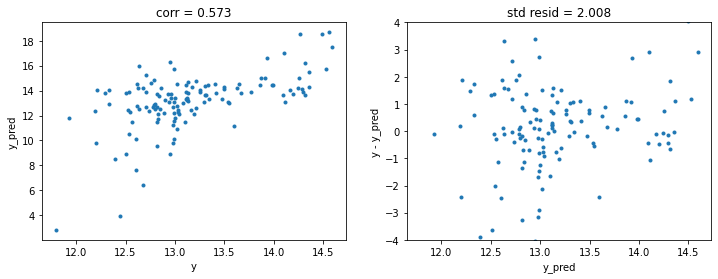

In [18]:
splits = 5
repeats = 5
model=Lasso()
lambda_range = np.arange(0,1,0.001)
param_grid ={
    'alpha': lambda_range
}
best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=scaled_x, y=data_y)




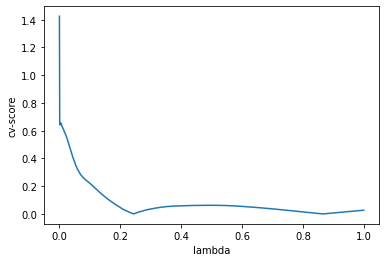


Best Score
mean    0.062352
std     0.089863
dtype: float64

Lambda
0.489


In [19]:
plt.plot(lambda_range, abs(grid_results['mean_test_score']))
plt.xlabel('lambda')
plt.ylabel('cv-score')
plt.show()
print()
print('Best Score')
print(cv_score)
print()
print('Lambda')
print(best_model.alpha)


In [20]:
feature_names=list(scaled_x.columns)
feature_coeff = best_model.coef_
df_importance = pd.Series(feature_coeff, index=feature_names)
df_importance

RBM5       0.0
CDC27      0.0
CREBBP     0.0
MED24      0.0
CSDE1      0.0
          ... 
HLA-B     -0.0
ARFGAP3    0.0
CEBPA     -0.0
CUX1      -0.0
TXNIP      0.0
Length: 451, dtype: float64

In [21]:
df_importance.nlargest(5)

TCF12    0.187155
VHL      0.169379
RPGR     0.098283
BCOR     0.088127
RBM5     0.000000
dtype: float64

In [32]:
features2 = list(df_drug_response.columns)[452:912]
data_x2=df_drug_response_drop.loc[:,features2]
data_y2=df_drug_response_drop['ERLOTINIB']
data_x2

,ABL2_mut,ACACA_mut,ACAD8_mut,ACO1_mut,ACSL3_mut,ACSL6_mut,ACTB_mut,ACTG1_mut,ACTG2_mut,ACVR1B_mut,...,ZC3H11A_mut,ZFHX3_mut,ZFP36L1_mut,ZFP36L2_mut,ZMYM2_mut,ZNF292_mut,ZNF638_mut,ZNF750_mut,ZNF814_mut,ZNRF3_mut
LC1SQSF_LUNG,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
NCIH1395_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LK2_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
NCIH446_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
LOUNH91_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH1581_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RERFLCAD1_LUNG,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
NCIH23_LUNG,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCIH1355_LUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
scaler = StandardScaler()
scaled_val = scaler.fit_transform(data_x2)
scaled_x = pd.DataFrame(scaled_val, columns=data_x2.columns)

Fitting 25 folds for each of 1000 candidates, totalling 25000 fits
----------------------
Lasso(alpha=0.467)
----------------------


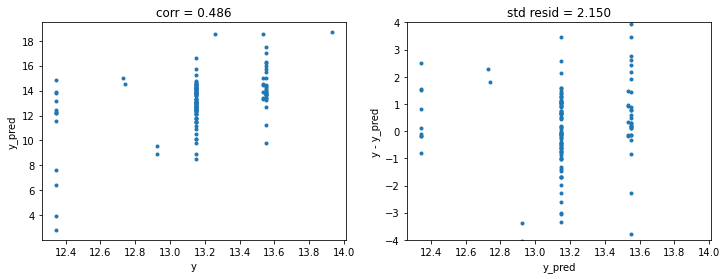

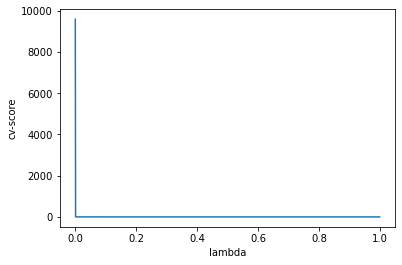


Best Score
mean    0.032215
std     0.092588
dtype: float64

Lambda
0.467


In [37]:
splits = 5
repeats = 5
model=Lasso()
lambda_range = np.arange(0,1,0.001)
param_grid ={
    'alpha': lambda_range
}
best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=scaled_x, y=data_y2)
plt.plot(lambda_range, abs(grid_results['mean_test_score']))
plt.xlabel('lambda')
plt.ylabel('cv-score')
plt.show()
print()
print('Best Score')
print(cv_score)
print()
print('Lambda')
print(best_model.alpha)



In [38]:
feature_names=list(scaled_x.columns)
feature_coeff = best_model.coef_
df_importance = pd.Series(feature_coeff, index=feature_names)
df_importance

ABL2_mut     -0.0
ACACA_mut     0.0
ACAD8_mut    -0.0
ACO1_mut     -0.0
ACSL3_mut     0.0
             ... 
ZNF292_mut    0.0
ZNF638_mut    0.0
ZNF750_mut   -0.0
ZNF814_mut    0.0
ZNRF3_mut     0.0
Length: 460, dtype: float64

In [39]:
df_importance.nlargest(5)

RB1_mut       0.164608
XRN1_mut      0.097956
ADAM10_mut    0.009370
ABL2_mut     -0.000000
ACACA_mut     0.000000
dtype: float64